# CASA I/O: CASACore Tables-based tutorial for extracting data from MS

This tutorial does exactly what the intro tutorial does but it uses CASA's lower-level interface, `casacore.tables`, instead of `casatools`. In my limited experience so far, I think that the `casacore.tables` code runs a bit faser than `casatools` but sacrifices some minor amounts of interpretability. 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.constants import c

# CASA listobs is still handy for inspection (not used for reading visibilities)
from casatasks import listobs

# python-casacore I/O
import casacore.tables as tables

### Step 0: Inspect your measurement set (note spectral windows (spws), numbers of channels, etc)

In [4]:
ms_path = "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub"  #path to your measurement set
assert os.path.exists(ms_path), f"MS not found: {ms_path}"

In [5]:
# Write listobs to a text file so you can quickly inspect SPWs/fields/scans
listobs_out = "listobs.txt"
listobs(vis=ms_path, listfile=listobs_out, overwrite=True)
print(f"Wrote: {listobs_out}")

Wrote: listobs.txt


In [6]:
# Quick SPW / datadesc overview
dd_tab  = tables.table(os.path.join(ms_path, "DATA_DESCRIPTION"), readonly=True)
spw_tab = tables.table(os.path.join(ms_path, "SPECTRAL_WINDOW"), readonly=True)
pol_tab = tables.table(os.path.join(ms_path, "POLARIZATION"), readonly=True)

dd_spw_ids = dd_tab.getcol("SPECTRAL_WINDOW_ID")   # (n_ddid,)
dd_pol_ids = dd_tab.getcol("POLARIZATION_ID")      # (n_ddid,)

ddids = np.arange(dd_spw_ids.size)
print("Available DATA_DESC_IDs:", ddids.tolist())

for ddid in ddids:
    spw_id = int(dd_spw_ids[ddid])
    chan_freq = spw_tab.getcell("CHAN_FREQ", spw_id)  # (nchan,)
    nchan = len(chan_freq)
    print(f"ddid={ddid:>3} -> spw={spw_id:>3} with nchan={nchan}")

dd_tab.close()
spw_tab.close()
pol_tab.close()

Successful readonly open of default-locked table /home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub/DATA_DESCRIPTION: 3 columns, 2 rows
Successful readonly open of default-locked table /home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub/SPECTRAL_WINDOW: 17 columns, 2 rows
Successful readonly open of default-locked table /home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub/POLARIZATION: 4 columns, 2 rows
Available DATA_DESC_IDs: [0, 1]
ddid=  0 -> spw=  0 with nchan=80
ddid=  1 -> spw=  1 with nchan=80


### Step 1 a): Select your SPW and load the relevant columns into memory 
In this example, we load the columns labeled `antenna1`, `antenna2`, `uvw`, `flag`, `flag_row`, `weight`, and `data` from `SPW 0`.

For combining observations with multiple SPWs, see the tutorial [here](https://viscube.readthedocs.io/en/latest/notebooks/combining_low_high_res_casa.html) instead.

In [7]:
datadescid = 0  # <-- set this to the ddid you want (single SPW setup)
data_column = "DATA"  # or "CORRECTED_DATA", this part depends on the preprocessing pipeline you used

In [8]:
t = tables.table(ms_path, readonly=True)

# Select only this DDID (single SPW / single data desc selection)
t_sel = t.query(f"DATA_DESC_ID=={int(datadescid)}")

nrow = t_sel.nrows()
print("Selected rows:", nrow)

Successful readonly open of default-locked table /home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub: 22 columns, 1298388 rows
Selected rows: 81795


In [9]:
ant1 = t_sel.getcol("ANTENNA1", 0, nrow)         # (nrow,)
ant2 = t_sel.getcol("ANTENNA2", 0, nrow)         # (nrow,)
uvw_m = t_sel.getcol("UVW", 0, nrow)             # often (3, nrow) in meters
flag_row = t_sel.getcol("FLAG_ROW", 0, nrow)     # (nrow,)

# FLAG is per-correlation/per-channel
flag = t_sel.getcol("FLAG", 0, nrow)

# WEIGHT: often per-row per-pol (npol, nrow) or (nrow, npol) depending on casacore build/MS
weight = t_sel.getcol("WEIGHT", 0, nrow)

# DATA (or CORRECTED_DATA)
data = t_sel.getcol(data_column, 0, nrow)

# close tables
t_sel.close()
t.close()

print("Raw shapes from casacore:")
print("  data:", data.shape)
print("  flag:", flag.shape)
print("  uvw_m:", uvw_m.shape)
print("  weight:", np.asarray(weight).shape)
print("  ant1/ant2:", ant1.shape, ant2.shape)
print("  flag_row:", flag_row.shape)

Raw shapes from casacore:
  data: (81795, 80, 2)
  flag: (81795, 80, 2)
  uvw_m: (81795, 3)
  weight: (81795, 2)
  ant1/ant2: (81795,) (81795,)
  flag_row: (81795,)


In [10]:
dd_tab  = tables.table(os.path.join(ms_path, "DATA_DESCRIPTION"), readonly=True)
spw_tab = tables.table(os.path.join(ms_path, "SPECTRAL_WINDOW"), readonly=True)
pol_tab = tables.table(os.path.join(ms_path, "POLARIZATION"), readonly=True)

spw_id = int(dd_tab.getcol("SPECTRAL_WINDOW_ID")[datadescid])
pol_id = int(dd_tab.getcol("POLARIZATION_ID")[datadescid])

chan_freq_hz = np.array(spw_tab.getcell("CHAN_FREQ", spw_id), dtype=float).flatten()  # (nchan,)
corr_type = np.array(pol_tab.getcell("CORR_TYPE", pol_id)).flatten()
npol = corr_type.size
nchan = chan_freq_hz.size

dd_tab.close()
spw_tab.close()
pol_tab.close()

print("spw_id:", spw_id, "pol_id:", pol_id)
print("npol:", npol, "nchan:", nchan)
print("chan_freq_hz:", chan_freq_hz.shape)


Successful readonly open of default-locked table /home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub/DATA_DESCRIPTION: 3 columns, 2 rows
Successful readonly open of default-locked table /home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub/SPECTRAL_WINDOW: 17 columns, 2 rows
Successful readonly open of default-locked table /home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub/POLARIZATION: 4 columns, 2 rows
spw_id: 0 pol_id: 0
npol: 2 nchan: 80
chan_freq_hz: (80,)


### Step 1 b): Standardize array axis order

In [12]:
def to_npol_nchan_nrow(arr, npol_expected, nchan_expected, nrow_expected=None, name="array"):
    """
    Convert casacore getcol output to (npol, nchan, nrow).

    Common shapes seen in the wild:
      - (nchan, npol, nrow)
      - (npol, nchan, nrow)
      - (nrow, nchan, npol)   <-- your case
      - (nrow, npol, nchan)
    """
    arr = np.asarray(arr)
    if arr.ndim != 3:
        raise ValueError(f"{name} expected 3D, got {arr.shape}")

    s0, s1, s2 = arr.shape

    # helper to sanity check optional nrow
    def _check_nrow(nrow_axis_len):
        return (nrow_expected is None) or (nrow_axis_len == nrow_expected)

    # (nchan, npol, nrow) -> (npol, nchan, nrow)
    if (s0 == nchan_expected) and (s1 == npol_expected) and _check_nrow(s2):
        return np.transpose(arr, (1, 0, 2))

    # already (npol, nchan, nrow)
    if (s0 == npol_expected) and (s1 == nchan_expected) and _check_nrow(s2):
        return arr

    # (nrow, nchan, npol) -> (npol, nchan, nrow)
    if _check_nrow(s0) and (s1 == nchan_expected) and (s2 == npol_expected):
        return np.transpose(arr, (2, 1, 0))

    # (nrow, npol, nchan) -> (npol, nchan, nrow)
    if _check_nrow(s0) and (s1 == npol_expected) and (s2 == nchan_expected):
        return np.transpose(arr, (1, 2, 0))

    raise ValueError(
        f"{name} has unexpected shape {arr.shape}; expected a permutation of "
        f"(npol, nchan, nrow)=({npol_expected}, {nchan_expected}, nrow)"
        + (f" with nrow={nrow_expected}" if nrow_expected is not None else "")
    )

# Convert to internal standard (npol, nchan, nrow)
data = to_npol_nchan_nrow(data, npol, nchan, nrow_expected=nrow, name=data_column)
flag = to_npol_nchan_nrow(flag, npol, nchan, nrow_expected=nrow, name="FLAG")

# UVW: usually (3, nrow); sometimes (nrow, 3)
uvw_m = np.asarray(uvw_m)
if uvw_m.shape == (nrow, 3):
    uvw_m = uvw_m.T
assert uvw_m.shape == (3, nrow), f"Unexpected UVW shape: {uvw_m.shape}"

print("Standardized shapes:")
print("  data:", data.shape)   # (npol, nchan, nrow)
print("  flag:", flag.shape)   # (npol, nchan, nrow)
print("  uvw_m:", uvw_m.shape) # (3, nrow)

Standardized shapes:
  data: (2, 80, 81795)
  flag: (2, 80, 81795)
  uvw_m: (3, 81795)


### Step 2: Regularize the shape of the WEIGHT column

CASA sometimes returns WEIGHT as (nrow,) or (1, nrow). We standardize it so later broadcasting works cleanly.

In [13]:
weight = np.asarray(weight)

if weight.ndim == 1:
    # (nrow,) -> replicate for each pol
    assert weight.shape[0] == nrow
    weight = np.tile(weight[None, :], (npol, 1))

elif weight.ndim == 2:
    # could be (npol, nrow) or (nrow, npol)
    if weight.shape == (npol, nrow):
        pass
    elif weight.shape == (nrow, npol):
        weight = weight.T
    elif weight.shape[0] == 1 and weight.shape[1] == nrow and npol > 1:
        weight = np.tile(weight, (npol, 1))
    else:
        raise ValueError(f"Unexpected WEIGHT shape: {weight.shape}")
else:
    raise ValueError(f"Unexpected WEIGHT ndim: {weight.ndim}, shape: {weight.shape}")

print("Normalized weight shape:", weight.shape)  # (npol, nrow)

Normalized weight shape: (2, 81795)


### Step 3: Flag data using FLAG_ROW

Apply FLAG_ROW to every polarization and channel

In [14]:
flag = np.logical_or(flag, flag_row[None, None, :])
print("Flagged fraction (including FLAG_ROW):", float(flag.mean()))

Flagged fraction (including FLAG_ROW): 0.09407665505226481


### Step 4: Remove autocorrelations

In [15]:
xc = np.where(ant1 != ant2)[0]

data = data[:, :, xc]
flag = flag[:, :, xc]
uvw_m = uvw_m[:, xc]
weight = weight[:, xc]

print("After autocorr removal:")
print("  data:", data.shape)
print("  flag:", flag.shape)
print("  uvw_m:", uvw_m.shape)
print("  weight:", weight.shape)

After autocorr removal:
  data: (2, 80, 77900)
  flag: (2, 80, 77900)
  uvw_m: (3, 77900)
  weight: (2, 77900)


### Step 5: Average polarizations (weighted), reshape flag to match

In [16]:
# Broadcast weight to match (npol, nchan, nvis)
w_b = weight[:, None, :]                  # (npol, 1, nvis)
wsum = np.sum(w_b, axis=0)                # (nchan, nvis)
wsum_safe = np.where(wsum > 0, wsum, 1.0)

data = np.sum(data * w_b, axis=0) / wsum_safe   # (nchan, nvis)
flag = np.any(flag, axis=0)                     # (nchan, nvis)
weight_row = np.sum(weight, axis=0)             # (nvis,)

print("After pol-avg:")
print("  data:", data.shape)
print("  flag:", flag.shape)
print("  weight_row:", weight_row.shape)

After pol-avg:
  data: (80, 77900)
  flag: (80, 77900)
  weight_row: (77900,)


### Step 6: Build flagged data mask

In [17]:
mask = ~flag  # (nchan, nvis)
print("Valid fraction:", float(mask.mean()))

Valid fraction: 0.9512195121951219


### Step 7: Convert UVW from meters to lambda

In [18]:
u_m, v_m, w_m = uvw_m
nu = chan_freq_hz[:, None]  # (nchan, 1)

u_lam = (u_m[None, :] * nu / c.value)  # (nchan, nvis)
v_lam = (v_m[None, :] * nu / c.value)  # (nchan, nvis)
w_lam = (w_m[None, :] * nu / c.value)  # (nchan, nvis)

print("u_lam/v_lam/w_lam:", u_lam.shape, v_lam.shape, w_lam.shape)

u_lam/v_lam/w_lam: (80, 77900) (80, 77900) (80, 77900)


### Step 8: Ensure frequencies are increasing

##### If working with continuum data, skip down to Step 8 (alternative for continuum data) instead!

In [19]:
is_increasing = np.all(np.diff(chan_freq_hz) > 0)
print("Frequency increasing?", is_increasing)

if not is_increasing:
    chan_freq_cube_hz = chan_freq_hz[::-1].copy()
    data_cube = data[::-1].copy()
    mask_cube = mask[::-1].copy()
    u_cube = u_lam[::-1].copy()
    v_cube = v_lam[::-1].copy()
    w_cube = w_lam[::-1].copy()
else:
    chan_freq_cube_hz = chan_freq_hz.copy()
    data_cube = data.copy()
    mask_cube = mask.copy()
    u_cube = u_lam.copy()
    v_cube = v_lam.copy()
    w_cube = w_lam.copy()

# weights as cube-shaped array (handy later; still no gridding here)
weight_cube = np.tile(weight_row[None, :], (data_cube.shape[0], 1)).astype(float)

print("Cube shapes:")
print("  data_cube:", data_cube.shape)
print("  mask_cube:", mask_cube.shape)
print("  u_cube:", u_cube.shape)
print("  weight_cube:", weight_cube.shape)

Frequency increasing? False
Cube shapes:
  data_cube: (80, 77900)
  mask_cube: (80, 77900)
  u_cube: (80, 77900)
  weight_cube: (80, 77900)


### Step 9: Inspect data and save

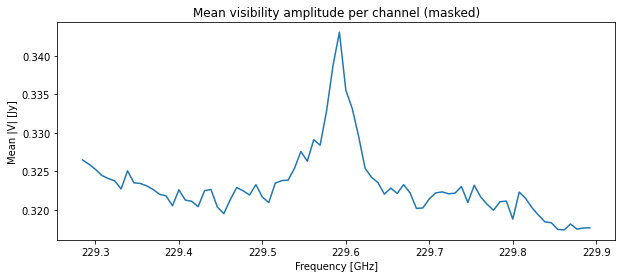

In [20]:
amp_mean = np.nanmean(np.where(mask_cube, np.abs(data_cube), np.nan), axis=1)

plt.figure(figsize=(10, 4))
plt.plot(chan_freq_cube_hz/1e9, amp_mean)
plt.xlabel("Frequency [GHz]")
plt.ylabel("Mean |V| [Jy]")
plt.title("Mean visibility amplitude per channel (masked)")
plt.show()

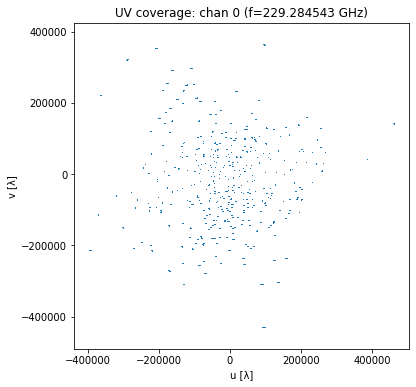

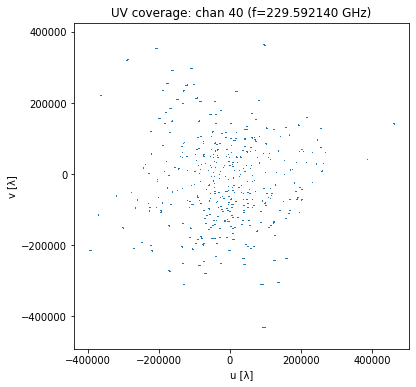

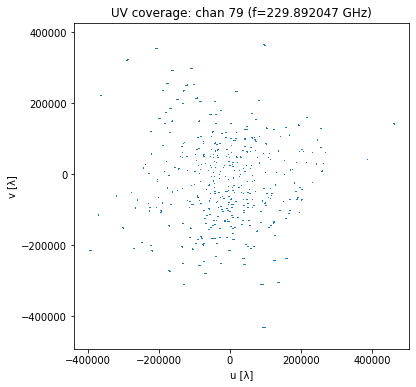

In [21]:
# UV coverage snapshots for a few channels
for k in [0, data_cube.shape[0]//2, data_cube.shape[0]-1]:
    valid_k = mask_cube[k]
    plt.figure(figsize=(6, 6))
    plt.scatter(u_cube[k, valid_k][::2], v_cube[k, valid_k][::2], s=1, linewidths=0)
    plt.xlabel("u [λ]"); plt.ylabel("v [λ]")
    plt.title(f"UV coverage: chan {k} (f={chan_freq_cube_hz[k]/1e9:.6f} GHz)")
    plt.axis("equal")
    plt.show()

In [ ]:
np.savez(
     "cube_extracted.npz",
     chan_freq_hz=chan_freq_cube_hz,
     u=u_cube, v=v_cube, w=w_cube,
     vis=data_cube,
     weight=weight_cube,
     mask=mask_cube,
)

########################################################################################################

### Step 8 (alternative for continuum data): Channel averaging and flattening across frequency

In [22]:
n_avg = 8  # fixed per your preference

nchan = data.shape[0]
n_new = (nchan // n_avg) * n_avg
print("nchan -> n_new:", nchan, "->", n_new)

# truncate to a multiple of n_avg
data_tr = data[:n_new]
u_tr = u_lam[:n_new]
v_tr = v_lam[:n_new]
w_tr = w_lam[:n_new]
mask_tr = mask[:n_new]
freq_tr = chan_freq_hz[:n_new]

# reshape (n_new/n_avg, n_avg, nvis) then average over the chunk axis
data_avg = data_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)
u_avg = u_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)
v_avg = v_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)
w_avg = w_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)

# mask: majority vote within chunk
mask_avg = mask_tr.astype(float).reshape(n_new // n_avg, n_avg, -1).mean(axis=1) > 0.5

# averaged channel frequencies
chan_freq_avg_hz = freq_tr.reshape(n_new // n_avg, n_avg).mean(axis=1)

print("Averaged shapes:")
print("  data_avg:", data_avg.shape)
print("  mask_avg:", mask_avg.shape)
print("  chan_freq_avg_hz:", chan_freq_avg_hz.shape)

nchan -> n_new: 80 -> 80
Averaged shapes:
  data_avg: (10, 77900)
  mask_avg: (10, 77900)
  chan_freq_avg_hz: (10,)


In [23]:
valid = mask_avg  # (nchan_avg, nvis)

u_cont = u_avg[valid]
v_cont = v_avg[valid]
w_cont = w_avg[valid]
vis_cont = data_avg[valid]

# broadcast weights to (nchan_avg, nvis), then apply mask+flatten
weight_chan = np.tile(weight_row[None, :], (data_avg.shape[0], 1))
wt_cont = weight_chan[valid].astype(float)

print("Continuum vectors:")
print("  u_cont:", u_cont.shape)
print("  v_cont:", v_cont.shape)
print("  w_cont:", w_cont.shape)
print("  vis_cont:", vis_cont.shape)
print("  wt_cont:", wt_cont.shape)

Continuum vectors:
  u_cont: (741000,)
  v_cont: (741000,)
  w_cont: (741000,)
  vis_cont: (741000,)
  wt_cont: (741000,)


### Step 9 (alternative for continuum data): Inspect data and save

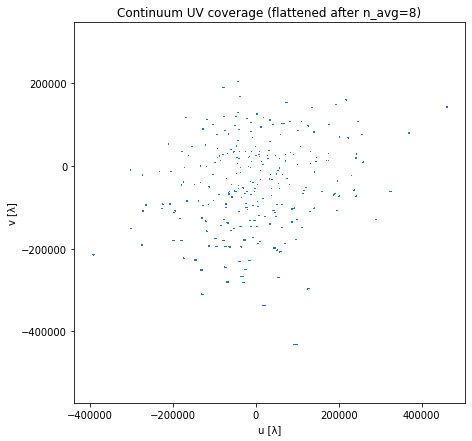

In [24]:
# UV coverage
step = max(1, u_cont.size // 200000)
plt.figure(figsize=(7, 7))
plt.scatter(u_cont[::step], v_cont[::step], s=1, linewidths=0)
plt.xlabel("u [λ]")
plt.ylabel("v [λ]")
plt.title("Continuum UV coverage (flattened after n_avg=8)")
plt.axis("equal")
plt.show()

In [ ]:
np.savez(
     "continuum_extracted_navg8.npz",
     u=u_cont, v=v_cont, w=w_cont,
     vis=vis_cont, weight=wt_cont,
     chan_freq_avg_hz=chan_freq_avg_hz,
)